# RealNVP训练现状介绍

### edited by mcy

&emsp;&emsp;距离RealNVP模型的实现过程有一个星期了，因此有必要总结一下当前的情况。

&emsp;&emsp;关于RealNVP的实现代码，2.9.0版本的tensorflow上有提供，但因为版本过高加上代码可读性有些差，最终没有使用。我是在苏剑林老师的博客中看到了两篇介绍flow模型的文章，里面比较详细的介绍了NICE、RealNVP和Glow模型(文章链接：https://kexue.fm/archives/5807 )，并且作者提供了Glow模型的keras代码。由于Glow是在RealNVP的基础上实现的，我在作者代码的基础上做了一些简单修改(去掉1*1可逆卷积模块、采用乘性耦合等)就大差不差地得到RealNVP的代码了。然而我本想尝试自己编写一个类似的代码，但在基本理解那些自定义类后发现自己对keras还是了解太少，只能说罗马并非一日建成的。Anyway，改好的RealNVP还是能用的。

&emsp;&emsp;那么接下来我就以主函数RealNVP.py文件中的代码为演示内容进行介绍吧。

&emsp;&emsp;首先是相关库的导入和数据集的载入。其中RealNVP的各个运算模块类存储在**nvp_layers.py**文件中。在数据集上，我是选用了CelebaA的人脸数据集作为训练集，从中随机抽取6万多张图片，并转换为32*32的尺寸，用生成器读入训练。RealNVP的单个flow模块深度为10，外部的深度为3。

In [1]:
from keras.layers import *
from keras.models import Model
from keras.datasets import cifar10
from keras.callbacks import Callback
from keras.optimizers import adam_v2
from nvp_layers import *
import imageio
import numpy as np
import glob
import os
from PIL import Image
from keras.models import load_model

#选择CelebaA数据集进行训练(从中随机选取6万张图片)，图片大小32*32*3
imgs = glob.glob('./CelebA_32_sample/*.jpg')
img_size = 32 #图像尺寸
depth = 10  # 单步flow运算内部的深度
level = 3  # flow模块数量

def imread(f):
    x = Image.open(f)
    x = np.array(x)
    x = x.astype(np.float32)
    return x / 255 * 2 - 1

#由于图像过多，采用生成器逐步读入
def data_generator(batch_size=64):
    X = []
    while True:
        np.random.shuffle(imgs)
        for f in imgs:
            X.append(imread(f))
            if len(X) == batch_size:
                X = np.array(X)
                yield X,X.reshape((X.shape[0], -1))
                X = []

&emsp;&emsp;之后，定义用于拟合耦合层中s和t函数的卷积神经网络，采用3次same卷积进行函数的拟合。

In [2]:
def build_basic_model(in_channel):
    _in = Input(shape=(None, None, in_channel))
    _ = _in
    hidden_dim = 512
    _ = Conv2D(hidden_dim,
               (3, 3),
               padding='same')(_)
    # _ = Actnorm(add_logdet_to_loss=False)(_)
    _ = Activation('relu')(_)
    _ = Conv2D(hidden_dim,
               (1, 1),
               padding='same')(_)
    # _ = Actnorm(add_logdet_to_loss=False)(_)
    _ = Activation('relu')(_)
    _ = Conv2D(in_channel,
               (3, 3),
               kernel_initializer='zeros',
               padding='same')(_)
    return Model(_in, _)

&emsp;&emsp;接下来是生成模型中encoder部分的初始化。对于一张图片输入，先为其加入噪声用于防止过拟合。之后，通过squeeze操作增加输入的通道数。再接着进入单个flow模块，利用Actnorm完成输入的尺度变换，减少不必要的像素维度，再通过Permute操作随机打乱输入通道。之后在仿射耦合层使用乘性耦合，同时输入待估计的s和t函数。得到的两部分输出沿轴拼接后输出。单个flow模块内多层重复以上操作后，输出到flow外的多尺度层。在多尺度层中，将输入对半分开并取其一输入到下一个flow模块。同时，由于该操作使得直接输出部分的分布变为了以另一半为条件的分布，需要在CondActnorm层对直接输出部分做类似的尺度变换。最后，将作为条件的另一半输入到新的flow模块中去。而对于最后一个flow模块的输出，由于不必再分割，其分布是独立的，做独立的尺度变换即可。

In [3]:
#模型squeeze操作的初始化
squeeze = Squeeze()
#inner_layers用于保存flow运算内部各层的变换过程
#outer_layers用于保存flow模块外的变换过程，二者都是为了之后更好的求逆
inner_layers = []
outer_layers = []
for i in range(5):
    inner_layers.append([])

for i in range(3):
    outer_layers.append([])


x_in = Input(shape=(img_size, img_size, 3))
x = x_in
x_outs = []  #用于分段存储输入

# 给输入加入噪声（add noise into inputs for stability.）
x = Lambda(lambda s: K.in_train_phase(s + 1./256 * K.random_uniform(K.shape(s)), s))(x)

#RealNVP的模型结构
for i in range(level):
    x = squeeze(x)  #squeeze操作增加通道数
    for j in range(depth):
        actnorm = Actnorm()  #代替banch normalization完成尺度变换
        permute = Permute(mode='random')  #打乱通道
        split = Split()  #沿通道轴拆分图像
        #仿射耦合层，由于squeeze操作，s和t的输入通道数随外循环成倍增加
        couple = CoupleWrapper(build_basic_model(3*2**(i+1)),build_basic_model(3*2**(i+1)))  
        concat = Concat()  #沿通道轴拼接图像
        inner_layers[0].append(actnorm)
        inner_layers[1].append(permute)
        inner_layers[2].append(split)
        inner_layers[3].append(couple)
        inner_layers[4].append(concat)
        x = actnorm(x)
        x = permute(x)
        x1, x2 = split(x)
        x1, x2 = couple([x1, x2])
        x = concat([x1, x2])
    if i < level-1:
        split = Split()
        condactnorm = CondActnorm() #外层的多尺度结构，基于一半输入计算另一半的条件分布
        reshape = Reshape()  #用于拉直矩阵
        outer_layers[0].append(split)
        outer_layers[1].append(condactnorm)
        outer_layers[2].append(reshape)
        x1, x2 = split(x)
        x_out = condactnorm([x2, x1])
        x_out = reshape(x_out)
        x_outs.append(x_out)
        x = x1
    else:
        for _ in outer_layers:
            _.append(None)

final_actnorm = Actnorm()  #最后一个flow输出不做分割，分布独立，故用普通的多尺度变换
final_concat = Concat()
final_reshape = Reshape()

x = final_actnorm(x)
x = final_reshape(x)
x = final_concat(x_outs+[x])

encoder = Model(x_in, x)

&emsp;&emsp;接着就可以查看encoder模型的结构了。因为内外层嵌套的缘故，模型看起来还是比较冗长的。随后在编译过程中对似然函数取负，将其第一部分，即$-\frac{1}{2}(\|f(x)\|)^2$和常数项加入到loss中。而雅各比行列式在尺度变换层和仿射耦合层已经加入到目标函数中。

In [4]:
encoder.summary()
encoder.compile(loss=lambda y_true,y_pred: 0.5 * K.sum(y_pred**2, 1) + 0.5 * np.log(2*np.pi) * K.int_shape(y_pred)[1],
                optimizer=adam_v2.Adam(1e-5))

Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
squeeze (Squeeze)               multiple             0           lambda[0][0]                     
                                                                 split_10[0][0]                   
                                                                 split_21[0][0]                   
___________________________________________________________________________________________

&emsp;&emsp;随后我们按搭建encoder时相反的操作搭建decoder，即生成模型。只能说苏老师太强了，把各个模块的逆变换都写好了！

In [5]:
x_in = Input(shape=K.int_shape(encoder.outputs[0])[1:])
x = x_in

x = final_concat.inverse()(x)
outputs = x[:-1]
x = x[-1]
x = final_reshape.inverse()(x)
x = final_actnorm.inverse()(x)
x1 = x


for i,(split,condactnorm,reshape) in enumerate(list(zip(*outer_layers))[::-1]):
    if i > 0:
        x1 = x
        x_out = outputs[-i]
        x_out = reshape.inverse()(x_out)
        x2 = condactnorm.inverse()([x_out, x1])
        x = split.inverse()([x1, x2])
    for j,(actnorm,permute,split,couple,concat) in enumerate(list(zip(*inner_layers))[::-1][i*depth: (i+1)*depth]):
        x1, x2 = concat.inverse()(x)
        x1, x2 = couple.inverse()([x1, x2])
        x = split.inverse()([x1, x2])
        x = permute.inverse()(x)
        x = actnorm.inverse()(x)
    x = squeeze.inverse()(x)


decoder = Model(x_in, x)

&emsp;&emsp;之后是利用生成器生成图像的函数以及用于保存训练参数以及每个epoch生成效果的回调函数。

In [6]:
def sample(path, std=1):
    """采样查看生成效果（generate samples per epoch）
    """
    n = 9 #随机生成n**2张人脸
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            decoder_input_shape = (1,) + K.int_shape(decoder.inputs[0])[1:]
            z_sample = np.array(np.random.randn(*decoder_input_shape)) * std
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size, 3)
            figure[i * img_size: (i + 1) * img_size,
                   j * img_size: (j + 1) * img_size] = digit
    figure = (figure + 1) / 2 * 255
    figure = np.clip(figure, 0, 255).astype('uint8')
    imageio.imwrite(path, figure)
    

#模型训练时的回调函数，用于每轮图像生成效果的记录以及模型最优参数的保存
class Evaluate(Callback):
    def __init__(self):
        self.lowest = 1e10
    def on_epoch_end(self, epoch, logs=None):
        global encoder
        path = './test_pic/test_%s.png' % epoch
        sample(path, 0.9)
        if logs['loss'] <= self.lowest:
            #记录损失最小的模型参数
            self.lowest = logs['loss']
            encoder.save_weights('./best_model/best_encoder.weights')
            #encoder.save('./best_model/model150.h5')
        elif logs['loss'] > 0 and epoch > 10:
            """在后面，loss一般为负数，一旦重新变成正数，
            就意味着模型已经崩溃，需要降低学习率。
            In general, loss is less than zero.
            If loss is greater than zero again, it means model has collapsed.
            We need to reload the best model and lower learning rate.
            """
            encoder.load_weights('./best_model/best_encoder.weights')
            #encoder.load_weights('./best_model/model150.h5')
            K.set_value(encoder.optimizer.lr, 1e-5)


evaluator = Evaluate()

&emsp;&emsp;现在万事俱备，就可以训练模型啦！我是最多设置了200个epoch(机箱实在太烫了，不敢跑下去了)，每个epoch从生成器中抽取3.2万张图片进行训练的。在此演示就用5个epoch训练并且不用回调函数了。

In [ ]:
encoder.fit_generator(data_generator(),
                      steps_per_epoch=500,
                      epochs=5)

&emsp;&emsp;好吧，Jupyter内存不够崩了。。。毕竟这种编辑器平时加载数据和运行程序就比较慢，果然不适合做这种大规模计算。算了，就载入一下训练好的模型看看吧。

In [6]:
#加载训练好的模型

import matplotlib.pyplot as plt

squeeze = Squeeze()
inner_layers = []
outer_layers = []
for i in range(5):
    inner_layers.append([])

for i in range(3):
    outer_layers.append([])


x_in = Input(shape=(img_size, img_size, 3))
x = x_in
x_outs = []  #用于分段存储输入

# 给输入加入噪声（add noise into inputs for stability.）
x = Lambda(lambda s: K.in_train_phase(s + 1./256 * K.random_uniform(K.shape(s)), s))(x)

#RealNVP的模型结构
for i in range(level):
    x = squeeze(x)  #squeeze操作增加通道数
    for j in range(depth):
        actnorm = Actnorm()  #代替banch normalization完成尺度变换
        permute = Permute(mode='random')  #打乱通道
        split = Split()  #沿通道轴拆分图像
        #仿射耦合层，由于squeeze操作，s和t的输入通道数随外循环成倍增加
        couple = CoupleWrapper(build_basic_model(3*2**(i+1)),build_basic_model(3*2**(i+1)))  
        concat = Concat()  #沿通道轴拼接图像
        inner_layers[0].append(actnorm)
        inner_layers[1].append(permute)
        inner_layers[2].append(split)
        inner_layers[3].append(couple)
        inner_layers[4].append(concat)
        x = actnorm(x)
        x = permute(x)
        x1, x2 = split(x)
        x1, x2 = couple([x1, x2])
        x = concat([x1, x2])
    if i < level-1:
        split = Split()
        condactnorm = CondActnorm() #外层的多尺度结构，基于一半输入计算另一半的条件分布
        reshape = Reshape()  #用于拉直矩阵
        outer_layers[0].append(split)
        outer_layers[1].append(condactnorm)
        outer_layers[2].append(reshape)
        x1, x2 = split(x)
        x_out = condactnorm([x2, x1])
        x_out = reshape(x_out)
        x_outs.append(x_out)
        x = x1
    else:
        for _ in outer_layers:
            _.append(None)

final_actnorm = Actnorm()  #最后一个flow输出不做分割，分布独立，故用普通的多尺度变换
final_concat = Concat()
final_reshape = Reshape()

x = final_actnorm(x)
x = final_reshape(x)
x = final_concat(x_outs+[x])

encoder1 = Model(x_in, x)

#encoder先载入权重
encoder1.load_weights('./best_model/best_encoder.weights')

#decoder模型搭建
x_in = Input(shape=K.int_shape(encoder1.outputs[0])[1:])
x = x_in

x = final_concat.inverse()(x)
outputs = x[:-1]
x = x[-1]
x = final_reshape.inverse()(x)
x = final_actnorm.inverse()(x)
x1 = x


for i,(split,condactnorm,reshape) in enumerate(list(zip(*outer_layers))[::-1]):
    if i > 0:
        x1 = x
        x_out = outputs[-i]
        x_out = reshape.inverse()(x_out)
        x2 = condactnorm.inverse()([x_out, x1])
        x = split.inverse()([x1, x2])
    for j,(actnorm,permute,split,couple,concat) in enumerate(list(zip(*inner_layers))[::-1][i*depth: (i+1)*depth]):
        x1, x2 = concat.inverse()(x)
        x1, x2 = couple.inverse()([x1, x2])
        x = split.inverse()([x1, x2])
        x = permute.inverse()(x)
        x = actnorm.inverse()(x)
    x = squeeze.inverse()(x)


decoder1 = Model(x_in, x)


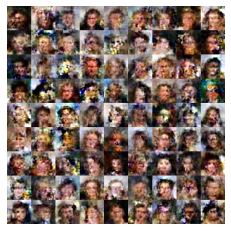

In [7]:
def sample1(decoder,std=1):
    """采样查看生成效果（generate samples per epoch）
    """
    n = 9 #随机生成n**2张人脸
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            decoder_input_shape = (1,) + K.int_shape(decoder1.inputs[0])[1:]
            z_sample = np.array(np.random.randn(*decoder_input_shape)) * std
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size, 3)
            figure[i * img_size: (i + 1) * img_size,
                   j * img_size: (j + 1) * img_size] = digit
    figure = (figure + 1) / 2 * 255
    figure = np.clip(figure, 0, 255).astype('uint8')
    figure=Image.fromarray(figure)
    
    plt.figure() 
    plt.imshow(figure)
    plt.axis('off')  
    plt.show()

#模型测试
sample1(decoder1,0.9)

&emsp;&emsp;至少从远处看每张图片都有人脸的轮廓以及大致五官了，尽管放大来看图片还是比较糊的。因此模型对人脸图像数据的分布有了大致的估计。与之对比，苏老师用Glow模型跑了150个epoch，模型生成的人脸要比上图清晰许多。一方面可能是因为Glow模型在引入1*1可逆卷积后，模型训练的loss下降更快，且乘性耦合变得不再必要，为模型节约了很多参数。另一方面可能是我修改文件中Arcnorm类的问题QAQ。

&emsp;&emsp;Glow中Arcnorm模块的作用是对输入进行尺度变换，从而减少图像中不必要的训练维度，这和RealNVP中的banchNormalization模块类似。但是在我使用乘性耦合后，模型在训练初期总是会出现loss为nan的问题。网上说这是尺度变换层中分母上的训练参数$\sigma$变为0导致的，因此我仿照banchNormalization的做法，在分母上加入了一个固定扰动$\varepsilon$来避免nan的出现。但是引入$\varepsilon$后又出现了一个问题：之前模型是将$log \frac{1}{\sigma}$整体作为权重s进行训练的，因而加入loss的雅各比行列式是$\sum{}{s}$，且图像对应的尺度变换是$e^s X$。但是这一变换在加入$\varepsilon$后就变得很奇怪了。此时的基础权重是$\sqrt{\sigma^2+\varepsilon}$，如果保持雅各比行列式和尺度变换的形式不变，我们理应在基础权重上加入$-log$运算将其变为$log\frac{1}{\sqrt{\sigma^2+\varepsilon}}$，以此作为新的s进行训练。然而，加入$-log$运算后的模型在训练时loss值经常为nan，反而是不加该运算的模型是可以正常训练的。这实在让我无法理解，以下是苏老师编写的Actnorm类的代码，我在其中添加了扰动项。

In [ ]:
class Actnorm(Layer):
    """缩放平移变换层（Scale and shift）
    """
    def __init__(self,
                 isinverse=False,
                 use_shift=True,
                 **kwargs):
        super(Actnorm, self).__init__(**kwargs)
        self.log_scale = None
        self.shift = None
        self.isinverse = isinverse
        self.use_shift = use_shift
    def build(self, input_shape):
        super(Actnorm, self).build(input_shape)
        kernel_shape = (1,)*(len(input_shape)-1) + (input_shape[-1],)
        if self.log_scale is None:
            #init=keras.initializers.RandomUniform(minval=1e-5, maxval=1e-4)
            #待估计的方差项
            self.log_scale = self.add_weight(name='log_scale',
                                             shape=kernel_shape,
                                             initializer='zeros',
                                             trainable=True)
            '''
            扰动项，防止分母为0，可用常数或随机数。该项有进一步的优化空间，
            对于随机扰动，目前来看选择正态分布的结果好于均匀分布,
            但正态分布情况下，模型在训练初期仍然会产生loss为nan的问题
            '''
            '''
            self.noise = self.add_weight(name='noise',
                                             shape=kernel_shape,
                                             initializer='random_normal',
                                             trainable=False)
            '''
            self.noise = 1e-3
            std=K.sqrt(self.log_scale + self.noise)
            #保证方差大于0
            self.total=K.maximum(std, K.sqrt(K.constant(self.noise)))
            
        if self.use_shift and self.shift is None:
            #待估计的均值项
            self.shift = self.add_weight(name='shift',
                                         shape=kernel_shape,
                                         initializer='zeros',
                                         trainable=True)
        if not self.use_shift:
            self.shift = 0.
    def call(self, inputs):
        if self.isinverse:
            #logdet = K.sum(self.log_scale)
            logdet = K.sum(self.total)
            #x_outs = K.exp(-self.log_scale) * (inputs - self.shift)
            x_outs = K.exp(-self.total) * (inputs - self.shift)
        else:
            #logdet = -K.sum(self.log_scale)
            logdet = -K.sum(self.total)
            #x_outs = K.exp(self.log_scale) * inputs + self.shift
            x_outs = K.exp(self.total) * inputs + self.shift
        if K.ndim(inputs) > 2:
            #这一步的目的不清楚诶。。。
            logdet *= K.prod(K.cast(K.shape(inputs)[1:-1], 'float32'))
        #self.logdet = logdet
        self.add_loss(logdet)
        return x_outs
    def inverse(self):
        layer = Actnorm(not self.isinverse)
        layer.log_scale = self.log_scale
        layer.shift = self.shift
        layer.total = self.total
        return layer
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'log_scale':self.log_scale,
            'shift':self.shift,
            'isinverse':self.isinverse,
            'use_shift':self.use_shift,
            'noise':self.noise,
            'total':self.total,
            })
        return config

&emsp;&emsp;当然关于$\sigma$和$\varepsilon$的初始设置也值得研究，上面的人脸图像是$\sigma$初值为0，$\varepsilon$为常数0.001条件下得到的结果。而当我把二者的初值设为(0,0.05)的正态分布随机数时，模型训练150个epoch后生成的图像如下：

![test_10d_150](./other_pic/test_10d_150.png)

这貌似比之前要清晰一些。但是此时并没有$\sigma^2>0$的约束，只要$\sigma^2+\varepsilon>0$即可，也是比较奇怪的。。。

&emsp;&emsp;尽管模型在随机生成人脸的质量上还需要进一步提高，但是对已有图片做编码解码操作还是能保留大部分图像信息的。如下，将32*32的川普头像输入到编码器encoder，得到中间的编码图片，再将编码图片输入到decoder进行解码。最终得到的图片除了在色调上与原图有些许差别，其他方面基本与原图相同。这或许说明RealNVP在数据加密传输领域有一定的应用价值，且训练出类似模型的成本要低于随机生成人脸的模型(因为可逆的模型结构是人为设定好的，只要各个参数不为零应该就可以实现，或许只用训练十几个或几个epoch就行)。

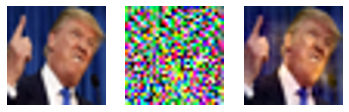

In [10]:
img_size=32
pic=Image.open('./trump.jpg')
pic=pic.resize((img_size,img_size));pic1=pic.resize((128,128))
pic=np.array(pic)
pic=pic.astype(np.float32)
pic=pic/ 255 * 2 - 1
pic=np.reshape(pic,[1,img_size,img_size,3])
pic_encoded = encoder1.predict(pic)[0]

pic_noise=pic_encoded.reshape(img_size,img_size,3)
pic_noise=(pic_noise + 1) / 2 * 255
pic_noise= np.clip(pic_noise, 0, 255).astype('uint8')
pic_noise=Image.fromarray(pic_noise)
pic2=pic_noise.resize((128,128))

pic_encoded=pic_encoded.reshape(1,img_size*img_size*3)
pic_decoded=decoder1.predict(pic_encoded * 0.9)[0]
pic_decoded=pic_decoded.reshape(img_size,img_size,3)
pic_decoded=(pic_decoded + 1) / 2 * 255
pic_decoded= np.clip(pic_decoded, 0, 255).astype('uint8')
pic_decoded=Image.fromarray(pic_decoded)
pic3=pic_decoded.resize((128,128))

plt.subplot(1,3,1);plt.imshow(pic1);plt.axis('off')
plt.subplot(1,3,2);plt.imshow(pic2);plt.axis('off')
plt.subplot(1,3,3);plt.imshow(pic3);plt.axis('off')
plt.show()

&emsp;&emsp;另外一个问题就是开头提到的加载训练好的模型参数问题。苏老师的代码里是用save_weight和load_weight保存和加载模型参数的，而模型的结构需要我们预先设定好。但是这样加载得到的模型无法继续进行训练。因此我尝试用save保存模型整体。我试过将自定义类中的属性加入到config中，再用save保存模型整体。但是自定义类中的numpy和tensor变量无法做Json的序列化存储(除非修改keras内部的代码)，因此这一方法未成功。目前不知道是否有其他保存整个模型的方法。

&emsp;&emsp;好了，这就是我目前实现的关于RealNVP的全部内容了。苏老师的代码让我学到了很多东西。但离生成清晰图像还有些距离的，看起来还是要恶补很多keras和tensorflow的知识才能把深度学习玩转啊~